# Code for $k$-commutativity

This notebook contains companion code for the paper [$k$-commutativity and measurement reduction for expectation values](https://arxiv.org/abs/2312.11840).

## Setup

In [1]:
!pip install cirq-core openfermion --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\andre\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import math
import os
from typing import Callable, Iterable, List, Set

import matplotlib.pyplot as plt
import numpy as np
import pprint
from tqdm.notebook import tqdm

import cirq
import openfermion as of

## The definition of $k$-commutativity

Any standard quantum software package will contain a function to check if two Pauli strings commute. (It's also simple to write such a function by checking the number of places the two strings disagree, modulo two, in the stabilizer representation.)

We show how to use this function from Cirq to check for $k$-commutativity as follows.

In [3]:
def restrict_to(
    pauli: cirq.PauliString, qubits: Iterable[cirq.Qid]
) -> cirq.PauliString:
    """Returns the Pauli string restricted to the provided qubits.

    Arguments:
        pauli: A Pauli string.
        qubits: A set of qubits.

    Returns:
        The provided Pauli string acting only on the provided qubits.
        Note: This could potentially be empty (identity).
    """
    return cirq.PauliString(p.on(q) for q, p in pauli.items() if q in qubits)


def commutes(pauli1: cirq.PauliString, pauli2: cirq.PauliString, k: int = 1) -> bool:
    """Returns True if pauli1 k-commutes with pauli2, else False.

    Arguments:
        pauli1: A Pauli string.
        pauli2: A Pauli string.
        k: The integer k in k-commutativity.
    """
    all_qubits = sorted(set(pauli1.qubits).union(pauli2.qubits))
    if k >= len(all_qubits):
        return cirq.commutes(pauli1, pauli2)

    blocks = [
        all_qubits[k * i : k * (i + 1)] for i in range(math.ceil(len(all_qubits) / k))
    ]
    for block in blocks:
        if not cirq.commutes(restrict_to(pauli1, block), restrict_to(pauli2, block)):
            return False
    return True

Some unit tests for this function are below.

In [4]:
"""Unit tests for k-commutativity."""
a, b, c, d = cirq.LineQubit.range(4)
pauli1 = cirq.Z.on(a) * cirq.Z.on(b) * cirq.X.on(c) * cirq.X.on(d)
pauli2 = cirq.X.on(a) * cirq.X.on(b) * cirq.X.on(c) * cirq.X.on(d)

assert not commutes(pauli1, pauli2, k=1)
assert commutes(pauli1, pauli2, k=2)
assert commutes(pauli2, pauli2, k=3)
assert commutes(pauli1, pauli2, k=4)

a, b, c, d, e = cirq.LineQubit.range(5)
pauli1 = cirq.Z.on(a) * cirq.I.on(b) * cirq.X.on(c) * cirq.I.on(d) * cirq.X.on(e)
pauli2 = cirq.Z.on(a) * cirq.Z.on(b) * cirq.X.on(c) * cirq.X.on(d) * cirq.X.on(e)

assert commutes(pauli1, pauli2, k=1)
assert commutes(pauli1, pauli2, k=2)
assert commutes(pauli1, pauli2, k=3)
assert commutes(pauli1, pauli2, k=4)
assert commutes(pauli1, pauli2, k=5)

## Helper functions for numerical experiments

### Sorted insertion

An implementation of the sorted insertion algorithm from https://quantum-journal.org/papers/q-2021-01-20-385/ is provided below.

In [5]:
def get_terms_ordered_by_abscoeff(op: of.QubitOperator) -> List[of.QubitOperator]:
    """Returns the terms of QubitOperator ordered by coefficient absolute value.

    Args:
        op: A QubitOperator.
    """
    terms = sorted(op.terms.items(), key=lambda x: abs(x[1]), reverse=True)
    return [of.QubitOperator(t[0], t[1]) for t in terms]


def get_si_sets(op, k: int = 1) -> List[List[of.QubitOperator]]:
    """Returns grouping from the sorted insertion algorithm [https://quantum-journal.org/papers/q-2021-01-20-385/].

    Args:
        op: The observable to group.
        k: The integer k in k-commutativity.
    """
    qo_to_ps = lambda qo: next(iter(of.transforms.qubit_operator_to_pauli_sum(qo)))
    comm_func = lambda ps1, ps2: commutes(qo_to_ps(ps1), qo_to_ps(ps2), k)

    commuting_sets = []
    for pstring in get_terms_ordered_by_abscoeff(op):
        found_commuting_set = False

        for commset in commuting_sets:
            cant_add = False

            for pauli in commset:
                if not comm_func(pstring, pauli):
                    cant_add = True
                    break

            if not cant_add:
                commset.append(pstring)
                found_commuting_set = True
                break

        if not found_commuting_set:
            commuting_sets.append([pstring])

    return commuting_sets

### The $\hat{R}$ metric

An implementation of the $\hat{R}$ metric from https://quantum-journal.org/papers/q-2021-01-20-385/ is provided below.

In [6]:
def compute_rhat(groupings):
    r_numerator = 0
    r_denominator = 0
    for group in groupings:
        if isinstance(group, of.QubitOperator):
            a_ij = sum(list(group.terms.values()))
            r_numerator += abs(a_ij)
            r_denominator += np.sqrt(abs(a_ij) ** 2)
        else:
            a_ij = np.array([list(op.terms.values())[0] for op in group])
            group_sum = np.sum(np.abs(a_ij))
            group_sum_squares = np.sum(np.abs(a_ij) ** 2)
            r_numerator += group_sum
            r_denominator += np.sqrt(group_sum_squares)
    return (r_numerator / r_denominator) ** 2

### Miscellaneous

In [7]:
def get_qubits(hamiltonian: of.QubitOperator) -> Set[int]:
    qubits = set()
    for term in hamiltonian.terms:
        for qubit_index, _ in term:
            qubits.add(qubit_index)
    return qubits


def get_num_qubits(hamiltonian: of.QubitOperator) -> int:
    return len(get_qubits(hamiltonian))

## The Fermi-Hubbard experiment

### Run the experiment

In [8]:
x_dimension = 4  # @param {type:"slider", min:1, max:8, step:1}
y_dimension = 5  # @param {type:"slider", min:1, max:8, step:1}
encoding = "bravyi-kitaev"  # @param ["jordan-wigner", "bravyi-kitaev"]
periodic = False  #@param {type:"boolean"}
spinless = True
tunneling = 2.0
coulomb = 1.0
magnetic_field = 0.5
chemical_potential = 0.25

hubbard_model = of.hamiltonians.fermi_hubbard(
    x_dimension, y_dimension, tunneling, coulomb, chemical_potential,
    magnetic_field, periodic, spinless)

encode = {
    "jordan-wigner": of.transforms.jordan_wigner,
    "bravyi-kitaev": of.transforms.bravyi_kitaev,
}.get(encoding)

hamiltonian = encode(hubbard_model)

# print("Number of qubits in Hamiltonian:", get_num_qubits(hamiltonian))
# print("Number of paulis in Hamiltonian:", len(hamiltonian.terms))

ngroups = []
rhats = []
kvals = np.arange(1, x_dimension * y_dimension + 1, 1)
for k in tqdm(kvals):
    groups = get_si_sets(hamiltonian, k=k)
    rhat = compute_rhat(groups)

    # print(f"Results for k = {k}")
    # print(f"# groups: {len(groups)}")
    # print(f"{rhat=}")
    ngroups.append(len(groups))
    rhats.append(rhat)


  0%|          | 0/20 [00:00<?, ?it/s]

### Plot the results

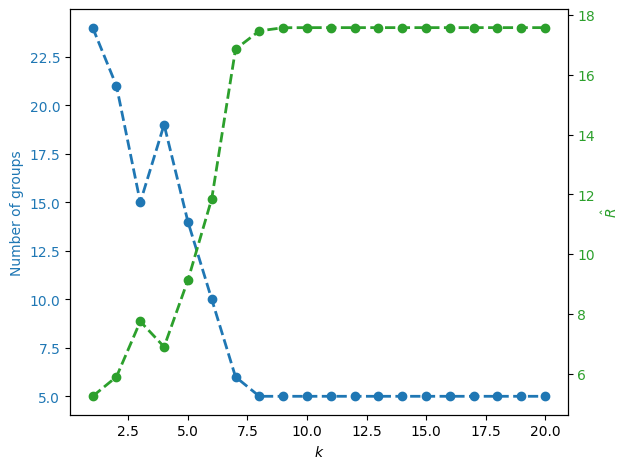

In [9]:
#@markdown Plotting code.
color1 = "tab:blue"
color2 = "tab:green"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(kvals, ngroups, "--o", color=color1, lw=2)
ax2.plot(kvals, rhats, "--o", color=color2, lw=2)

ax1.set_xlabel("$k$")
ax1.set_ylabel("Number of groups", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

ax2.set_ylabel("$\hat{R}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.tight_layout();

## Molecular Hamiltonians experiment

This section reproduces the molecular Hamiltonians experiment using Hamiltonians from [HamLib](https://portal.nersc.gov/cfs/m888/dcamps/hamlib/).

### Downloading data from HamLib

In [10]:
%%shell
url="https://portal.nersc.gov/cfs/m888/dcamps/hamlib/chemistry/electronic/standard/"
molecules="O2 B2 BeH BH CH HF C2 OH N2 Li2 NaLi"

for molecule in $molecules
do
  echo "Downloading $url$molecule.hdf5.zip"
  curl -s "$url$molecule.hdf5.zip" -L -o "$molecule.hdf5.zip" > /dev/null
  unzip -o -qq "$molecule.hdf5.zip"
  rm "$molecule.hdf5.zip"
done

UsageError: Cell magic `%%shell` not found.


### Loading data from HamLib

In [11]:
import h5py


def read_openfermion_hdf5(fname_hdf5: str, key: str, optype=of.QubitOperator):
    """
    Read any openfermion operator object from HDF5 file at specified key.
    'optype' is the op class, can be of.QubitOperator or of.FermionOperator.
    """

    with h5py.File(fname_hdf5, 'r', libver='latest') as f:
        op = optype(f[key][()].decode("utf-8"))
    return op


def parse_through_hdf5(func):
    """
    Decorator function that iterates through an HDF5 file and performs
    the action specified by ‘ func ‘ on the internal and leaf nodes in the HDF5 file.
    """

    def wrapper (obj, path = '/', key = None) :
        if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
            for ky in obj.keys() :
                func(obj, path, key=ky, leaf = False)
                wrapper(obj = obj[ky], path = path + ky + ',', key = ky)
        elif type (obj) == h5py._hl.dataset.Dataset:
            func(obj, path, key = None, leaf = True)
    return wrapper


def get_hdf5_keys ( fname_hdf5 : str ) :
    """ Get a list of keys to all datasets stored in the HDF5 file .
    Args
    ----
    fname_hdf5 ( str ) : full path where HDF5 file is stored
    """

    all_keys = []
    @parse_through_hdf5
    def action(obj, path = '/', key = None, leaf = False):
        if leaf is True :
            all_keys.append(path)

    with h5py.File(fname_hdf5, 'r') as f:
        action(f['/'])
    return all_keys

### Helper functions

In [12]:
def preprocess_hamiltonian(
    hamiltonian: of.QubitOperator,
    drop_term_if: Iterable[Callable[[], bool]] | None = None,
) -> of.QubitOperator:
    if drop_term_if is None:
        drop_term_if = []

    new = of.QubitOperator()

    for term in hamiltonian.terms:
        add_term = True

        for drop_term in drop_term_if:
            if drop_term(term):
                add_term = False
                break

        if add_term:
            key = " ".join(pauli + str(index) for index, pauli in term)
            new += of.QubitOperator(key, hamiltonian.terms.get(term))

    return new

### Run the experiment

In [13]:
#@markdown Run the experiment.
data_directory: str = "./"
extension: str = ".hdf5"
fnames_encodings = {
    "O2": "/ham_JW16",
    "B2": "/ham_JW-10",
    "BeH": "/ham_JW10",
    "BH": "/ham_JW-10",
    "CH": "/ham_JW-10",
    "HF": "/ham_JW10",
    "C2": "/ham_JW-10",
    "OH": "/ham_JW10",
    "N2": "/ham_JW-14",
    "Li2": "/ham_JW10",
    "NaLi": "/ham_JW-14",
}
fnames = list(fnames_encodings.keys())
fermion_to_qubit_mapping_key: int = 0

all_rhats = []
all_ngroups = []

for i, fname in enumerate(fnames):
    print(fname)
    hamiltonian = read_openfermion_hdf5(
        os.path.join(data_directory, fname + extension),
        get_hdf5_keys(os.path.join(data_directory, fname + extension))[fermion_to_qubit_mapping_key].rstrip(","),  # Or # fnames_encodings[fname]
    )
    hamiltonian = preprocess_hamiltonian(hamiltonian, drop_term_if=[lambda term: term == ()])  # Drop identity.

    nqubits = get_num_qubits(hamiltonian)
    nterms = len(hamiltonian.terms)
    print(f"Hamiltonian has {nterms} term(s) and acts on {nqubits} qubit(s).")

    grouping_algorithms = {
        lambda ham: get_si_sets(ham, k=1): "1-qubit-wise commuting",
        lambda ham: get_si_sets(ham, k=nqubits // 4): f"{nqubits // 4}-qubit-wise commuting",
        lambda ham: get_si_sets(ham, k=nqubits // 2): f"{nqubits // 2}-qubit-wise commuting",
        lambda ham: get_si_sets(ham, k=3 * nqubits // 4): f"{3 * nqubits // 4}-qubit-wise commuting",
        lambda ham: get_si_sets(ham, k=nqubits): "Fully commuting",
    }

    metric_groups = {label: group(hamiltonian) for group, label in grouping_algorithms.items()}

    ngroups = {label: len(groups) for label, groups in metric_groups.items()}
    print("Number of groups:")
    pprint.pprint(ngroups)
    all_ngroups.append(ngroups)

    rhats = {label: compute_rhat(groups) for label, groups in metric_groups.items()}
    print("Rhat values:")
    pprint.pprint(rhats)
    all_rhats.append(rhats)

O2


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './O2.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Plot the results

#### Number of groups

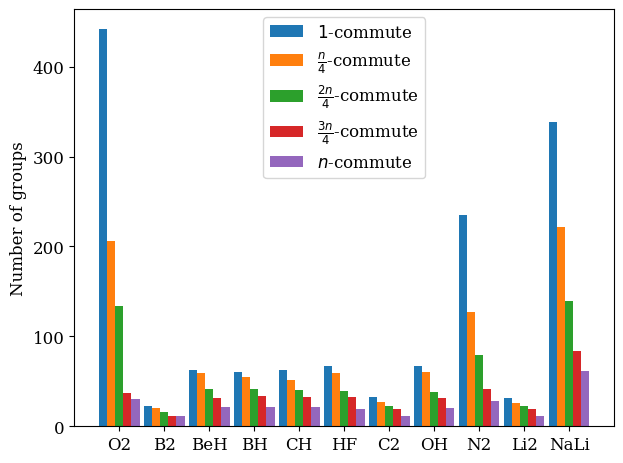

In [ ]:
#@markdown Plotting code.
# Parse data.
ngroups_to_plot = []

for ngroups in all_ngroups:
    ngroups_to_plot.append(list(ngroups.values()))

ngroups_to_plot = np.array(ngroups_to_plot)

# Plot.
plt.rcParams.update({"font.family": "serif", "font.size": 12})

xs = np.arange(len(fnames))
width = 2.0 / len(xs)

for i, rhats in enumerate(ngroups_to_plot.T):
    plt.bar(xs + (i - len(ngroups_to_plot.T) // 2) * width, rhats, width=width, align="center")

plt.xticks(xs, labels=fnames)
plt.ylabel("Number of groups")
plt.legend(["$1$-commute", r"$\frac{n}{4}$-commute", r"$\frac{2n}{4}$-commute", r"$\frac{3n}{4}$-commute", "$n$-commute"])
plt.tight_layout()

#### Values of $\hat{R}$

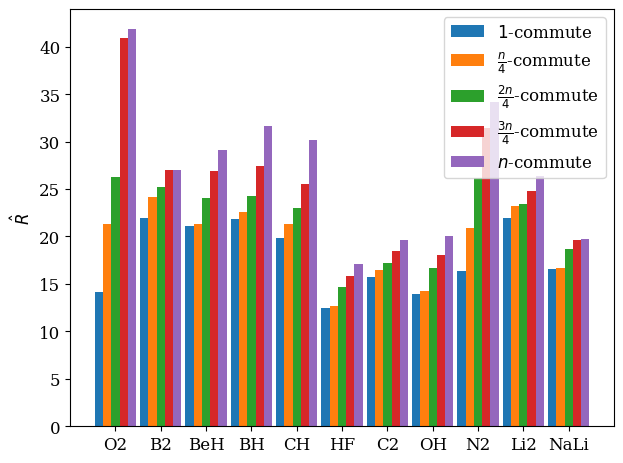

In [ ]:
#@markdown Plotting code.
# Parse data.
rhats_to_plot = []

for rhats in all_rhats:
    rhats_to_plot.append(list(rhats.values()))

rhats_to_plot = np.array(rhats_to_plot)

# Plot.
plt.rcParams.update({"font.family": "serif", "font.size": 12})

xs = np.arange(len(fnames))
width = 2.0 / len(xs)

for i, rhats in enumerate(rhats_to_plot.T):
    plt.bar(xs + (i - len(rhats_to_plot.T) // 2) * width, rhats, width=width, align="center")

plt.xticks(xs, labels=fnames)
plt.ylabel(r"$\hat{R}$")
plt.legend(["$1$-commute", r"$\frac{n}{4}$-commute", r"$\frac{2n}{4}$-commute", r"$\frac{3n}{4}$-commute", "$n$-commute"])
plt.tight_layout()

Comments and corrections welcome to rmlarose@msu.edu.